In [271]:
import torch
from torchvision import transforms, datasets
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
import os
import numpy as np
from sklearn.manifold import TSNE

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

transform = transforms.Compose([
    transforms.ToTensor(),
])

train_dataset = datasets.MNIST(root="./data", train=True, transform=transform, download=True)
test_dataset = datasets.MNIST(root="./data", train=False, transform=transform, download=True)

train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False)

In [272]:
class DenseEncoder(nn.Module):
    def __init__(self, input_dim=784, latent_dim=20, hidden_dims=[512, 256]):
        super(DenseEncoder, self).__init__()
        self.fc_layers = nn.ModuleList()
        prev_dim = input_dim
        for h_dim in hidden_dims:
            self.fc_layers.append(nn.Linear(prev_dim, h_dim))
            prev_dim = h_dim
        
        self.fc_mu = nn.Linear(prev_dim, latent_dim)
        self.fc_logvar = nn.Linear(prev_dim, latent_dim)
        
    def forward(self, x):
        x = x.view(x.size(0), -1) 
        for layer in self.fc_layers:
            x = F.relu(layer(x))
        mu = self.fc_mu(x)
        logvar = self.fc_logvar(x)
        return mu, logvar

In [273]:
class ConvEncoder(nn.Module):
    def __init__(self, latent_dim=10):
        super(ConvEncoder, self).__init__()
        self.conv_layers = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=0),
            nn.ReLU(),
        )
        self.flatten = nn.Flatten()
        self.fc_mu = nn.Linear(128 * 5 * 5, latent_dim)
        self.fc_logvar = nn.Linear(128 * 5 * 5, latent_dim)

    def forward(self, x):
        x = self.conv_layers(x)
        x = self.flatten(x)
        mu = self.fc_mu(x)
        logvar = self.fc_logvar(x)
        return mu, logvar

In [274]:
class DenseDecoder(nn.Module):
    def __init__(self, latent_dim=20, output_dim=784, hidden_dims=[256, 512]):
        super(DenseDecoder, self).__init__()
        self.fc_layers = nn.ModuleList()
        prev_dim = latent_dim
        for h_dim in hidden_dims:
            self.fc_layers.append(nn.Linear(prev_dim, h_dim))
            prev_dim = h_dim

        self.fc_out = nn.Linear(prev_dim, output_dim)

    def forward(self, z):
        x = z
        for layer in self.fc_layers:
            x = F.relu(layer(x))
        x = torch.sigmoid(self.fc_out(x))  
        x = x.view(-1, 1, 28, 28)        
        return x

In [275]:
class ConvDecoder(nn.Module):
    def __init__(self, latent_dim=20):
        super(ConvDecoder, self).__init__()
        self.fc = nn.Linear(latent_dim, 128 * 5 * 5)
        self.deconv_layers = nn.Sequential(
            nn.ConvTranspose2d(128, 64, kernel_size=3, stride=1, padding=0),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 32, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 1, kernel_size=4, stride=2, padding=1),
            nn.Sigmoid()
        )

    def forward(self, z):
        x = F.relu(self.fc(z))
        x = x.view(-1, 128, 5, 5)
        x = self.deconv_layers(x)
        return x

In [276]:
class VAE(nn.Module):
    def __init__(self, encoder, decoder):
        super(VAE, self).__init__()
        self.encoder = encoder
        self.decoder = decoder

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        z = mu + eps * std
        return z

    def forward(self, x):
        mu, logvar = self.encoder(x)
        z = self.reparameterize(mu, logvar)
        x_recon = self.decoder(z)
        return x_recon, mu, logvar

    def decode(self, z):
        return self.decoder(z)

    def encode(self, x):
        return self.encoder(x)

In [277]:
latent_dim = 10

# encoder = DenseEncoder(input_dim=784, latent_dim=latent_dim, hidden_dims=[512, 256])
# decoder = DenseDecoder(latent_dim=latent_dim, output_dim=784, hidden_dims=[256, 512])

encoder = ConvEncoder(latent_dim=latent_dim)
decoder = ConvDecoder(latent_dim=latent_dim)

vae = VAE(encoder, decoder).to(device)

optimizer = optim.Adam(vae.parameters(), lr=1e-3)

In [278]:
def count_parameters(model):
    """
    Retourne le nombre total de paramètres entraînables dans un modèle PyTorch.
    """
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

total_params = count_parameters(encoder) + count_parameters(decoder)
print(f"Nombre total de paramètres : {total_params}")

Nombre total de paramètres : 313557


In [279]:
def vae_loss(x_recon, x, mu, logvar, beta=10):
    recon_loss = F.binary_cross_entropy(x_recon, x, reduction='sum')
    kl_loss = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return (recon_loss + beta * kl_loss) / x.size(0)

In [280]:
def train_vae(model, dataloader, optimizer, num_epochs=10):
    model.train()
    for epoch in range(num_epochs):
        train_loss = 0
        for x, _ in dataloader:
            x = x.to(device)
            optimizer.zero_grad()
            x_recon, mu, logvar = model(x)
            loss = vae_loss(x_recon, x, mu, logvar)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
        
        avg_loss = train_loss / len(dataloader.dataset)
        print(f"Epoch [{epoch+1}/{num_epochs}] - Average loss: {avg_loss:.4f}")

In [281]:
train_vae(vae, train_loader, optimizer, num_epochs=20)

Epoch [1/20] - Average loss: 1.7018
Epoch [2/20] - Average loss: 1.4846
Epoch [3/20] - Average loss: 1.4604
Epoch [4/20] - Average loss: 1.4490
Epoch [5/20] - Average loss: 1.4426
Epoch [6/20] - Average loss: 1.4381
Epoch [7/20] - Average loss: 1.4359
Epoch [8/20] - Average loss: 1.4313
Epoch [9/20] - Average loss: 1.4321
Epoch [10/20] - Average loss: 1.4291
Epoch [11/20] - Average loss: 1.4277
Epoch [12/20] - Average loss: 1.4268
Epoch [13/20] - Average loss: 1.4254
Epoch [14/20] - Average loss: 1.4243
Epoch [15/20] - Average loss: 1.4241
Epoch [16/20] - Average loss: 1.4228
Epoch [17/20] - Average loss: 1.4215
Epoch [18/20] - Average loss: 1.4211
Epoch [19/20] - Average loss: 1.4200
Epoch [20/20] - Average loss: 1.4196


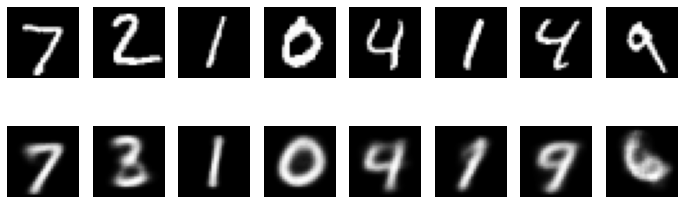

In [282]:
vae.eval()
with torch.no_grad():
    x, _ = next(iter(test_loader))
    x = x.to(device)
    x_recon, _, _ = vae(x)

    x = x.cpu()
    x_recon = x_recon.cpu()

    n = 8
    plt.figure(figsize=(12, 4))
    for i in range(n):
        plt.subplot(2, n, i + 1)
        plt.imshow(x[i].squeeze(), cmap='gray')
        plt.axis('off')
        
        plt.subplot(2, n, i + 1 + n)
        plt.imshow(x_recon[i].squeeze(), cmap='gray')
        plt.axis('off')
    plt.show()

In [283]:
def generate_samples(vae, latent_dim=2, n_samples=25, device='cpu'):
    vae.eval()
    with torch.no_grad():
        z = torch.randn(n_samples, latent_dim).to(device)
        generated = vae.decode(z).cpu()
        if generated.dim() == 2:
            generated = generated.view(-1, 1, 28, 28)
    return generated

def plot_generated_images(images, latent_dim, n_rows=5, n_cols=5, save_dir="results"):
    os.makedirs(save_dir, exist_ok=True)
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(6,6))
    for i, ax in enumerate(axes.flat):
        ax.imshow(images[i][0], cmap='gray')
        ax.axis('off')
    plt.suptitle(f"Images générées par le VAE (latent_dim={latent_dim})", fontsize=14)
    save_path = os.path.join(save_dir, f"images_gen_latent{latent_dim}.png")
    plt.savefig(save_path, bbox_inches='tight')
    plt.close(fig)
    print(f"Image enregistrée : {save_path}")

def plot_latent_space(vae, data_loader, device='cpu', latent_dim=2, save_dir="results"):
    os.makedirs(save_dir, exist_ok=True)
    vae.eval()
    all_mu, all_labels = [], []

    with torch.no_grad():
        for x, y in data_loader:
            x = x.to(device)
            mu, logvar = vae.encode(x)
            all_mu.append(mu.cpu().numpy())
            all_labels.append(y.numpy())

    all_mu = np.concatenate(all_mu)
    all_labels = np.concatenate(all_labels)

    if latent_dim > 2:
        all_mu_2d = TSNE(n_components=2, learning_rate='auto', init='random').fit_transform(all_mu)
    else:
        all_mu_2d = all_mu

    plt.figure(figsize=(8,6))
    scatter = plt.scatter(all_mu_2d[:, 0], all_mu_2d[:, 1], c=all_labels, cmap='tab10', s=5)
    plt.colorbar(scatter, label='Chiffre réel')
    plt.title(f"Représentation de l’espace latent (latent_dim={latent_dim})")
    plt.xlabel("z₁")
    plt.ylabel("z₂")

    save_path = os.path.join(save_dir, f"latent_space_latent{latent_dim}.png")
    plt.savefig(save_path, bbox_inches='tight')
    plt.close()
    print(f"Image enregistrée : {save_path}")

def interpolate_points(z1, z2, n_steps=10):
    ratios = np.linspace(0, 1, n_steps)
    return torch.stack([(1 - r) * z1 + r * z2 for r in ratios])

def plot_interpolation(vae, latent_dim=2, device='cpu', save_dir="results"):
    os.makedirs(save_dir, exist_ok=True)
    vae.eval()
    z1, z2 = torch.randn(2, latent_dim).to(device)
    z_interp = interpolate_points(z1, z2, n_steps=10)

    with torch.no_grad():
        imgs = vae.decode(z_interp).cpu().view(-1, 28, 28)

    fig, axes = plt.subplots(1, 10, figsize=(10,1))
    for i, ax in enumerate(axes.flat):
        ax.imshow(imgs[i], cmap='gray')
        ax.axis('off')
    plt.suptitle(f"Interpolation dans l’espace latent (latent_dim={latent_dim})", fontsize=14)
    save_path = os.path.join(save_dir, f"interpolation_latent{latent_dim}.png")
    plt.savefig(save_path, bbox_inches='tight')
    plt.close(fig)
    print(f"Image enregistrée : {save_path}")

In [284]:
generated = generate_samples(vae, latent_dim, n_samples=25, device=device)
plot_generated_images(generated, latent_dim)

plot_latent_space(vae, test_loader, device=device, latent_dim=latent_dim)

plot_interpolation(vae, latent_dim=latent_dim, device=device)

Image enregistrée : results/images_gen_latent10.png
Image enregistrée : results/latent_space_latent10.png
Image enregistrée : results/interpolation_latent10.png
